In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['NUM_WORKERS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [4]:
data_path = "/media/HlabShare/Gemechu_work/others"

In [5]:
df = pd.read_csv(f'{data_path}/window_analysis_tw_300_10_new.csv')
df = df[df.state!='REM']

In [6]:
df

,animal,block,subblock,window_index,condition,state,window_start_s,window_end_s,rho,chi,...,ang_sec_l2,spg_l2,eigvar_l2,eigent_l2,in_deg_l2,out_deg_l2,max_osc_growth2,avg_osc_growth2,avg_path2,avg_path_trad2
0,XYF03,1,0,0,dark,wake,0,300,0.055550,0.002142,...,0.000000,0.250907,0.006097,3.288537,0.326306,0.326306,0.014401,-0.027420,1.925813,80.587774
1,XYF03,1,0,1,dark,wake,148,448,0.063744,0.002108,...,0.000000,0.076384,0.002683,3.340736,0.191698,0.191698,0.014122,-0.021038,2.170213,95.204430
2,XYF03,1,0,2,dark,wake,296,596,0.068384,0.002032,...,0.000000,0.044928,0.001563,3.359637,0.119131,0.119131,0.006045,-0.013310,2.798734,129.047314
3,XYF03,1,0,3,dark,wake,444,744,0.069997,0.002292,...,0.000000,0.112251,0.001652,3.436489,0.150140,0.150140,0.020344,-0.020970,2.336287,109.295263
4,XYF03,1,0,4,dark,wake,592,892,0.075957,0.002541,...,0.000000,0.097666,0.001890,3.417169,0.161237,0.161237,0.024987,-0.015493,2.268946,103.654342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,XYF22,18,3,49,light,NREM,7252,7552,0.041171,0.001712,...,0.000000,0.332783,0.006720,3.007001,0.297649,0.297649,0.010485,-0.022187,1.873961,70.496255
8462,XYF22,18,3,53,light,NREM,7844,8144,0.037848,0.001653,...,0.000000,0.462616,0.008361,3.021553,0.343173,0.343173,0.014379,-0.027555,1.773826,64.645668
8463,XYF22,18,3,54,light,NREM,7992,8292,0.037869,0.001625,...,0.000000,0.400833,0.008089,2.992407,0.337870,0.337870,0.020684,-0.022972,1.798920,64.693827
8464,XYF22,18,3,65,light,NREM,9620,9920,0.045237,0.001796,...,3.141593,0.366561,0.006049,3.039931,0.281093,0.281093,0.020295,-0.023171,1.896122,70.739210


In [7]:
df.columns

Index(['animal', 'block', 'subblock', 'window_index', 'condition', 'state',
       'window_start_s', 'window_end_s', 'rho', 'chi', 'cv', 'br', 'maxe_l0',
       'sece_l0', 'ang_sec_l0', 'spg_l0', 'eigvar_l0', 'eigent_l0',
       'in_deg_l0', 'out_deg_l0', 'avg_path0', 'avg_path_trad0', 'maxe_l1',
       'ang_max_l1', 'sece_l1', 'ang_sec_l1', 'spg_l1', 'eigvar_l1',
       'eigent_l1', 'in_deg_l1', 'out_deg_l1', 'max_osc_growth1',
       'avg_osc_growth1', 'avg_path1', 'avg_path_trad1', 'maxe_l2',
       'ang_max_l2', 'sece_l2', 'ang_sec_l2', 'spg_l2', 'eigvar_l2',
       'eigent_l2', 'in_deg_l2', 'out_deg_l2', 'max_osc_growth2',
       'avg_osc_growth2', 'avg_path2', 'avg_path_trad2'],
      dtype='object')

In [8]:
summary_table = (
    df.groupby(['animal', 'block'])['subblock']
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
summary_table

subblock       0   1   2   3
animal block                
XYF03  1      66  54  71   0
       2      51  39  37   0
       3      54  45  58   0
       4      43  47  52   0
       5      45  55  65   0
       6      46  49  48   0
       7      65  41  66   0
XYF12  1      60  52  61   0
       2      61  52  51   0
       3      59  51  57   0
       4      70  65  62   0
       5      55  65  48   0
       6      75  51  47   0
       8      65  44  83   0
       11     48  47  49   0
       12     72  59  66   0
       13     49  53  57   0
       17     68  54  57   0
XYF13  1      73  56  58   0
       2      54  46  57   0
       5      66  56  48   0
       6      77  60  46   0
       7      60  65  58   0
XYF14  1      60  44  41   0
       2      58  63  59   0
       3      63  55  50   0
       4      57  59  56   0
       5      59  68  55   0
       6      59  52  60   0
       8      58  65  55   0
       11     42  56  43   0
       12     60  72  59   0
       13     46  52  40   0
       14     60  74  64   0
       16     55  66  56   0
       17     54  50  47   0
XYF22  4      50  47  43  47
       5      37  34  56  47
       6      46  57  33  47
       7      48  39  49  37
       8      53  64  48  49
       11     36  32  48  41
       12     55  51  31  40
       13     37  37  50  48
       14     47  47  40  26
       15     36  36  50  43
       16     50  66  31  24
       17     39  29  48  25
       18     32  54  40  39

### Use TimeSeriesMLProcessor to create moving window features
#### On each time step, columns of past time step features are added (as many as window_size)
#### Also statistics (mean, std etc) on the given window are calculated

In [9]:
processor = utils.TimeSeriesMLProcessor(df)
processed_df = processor.create_moving_windows(window_size=5, include_raw_windows=True)

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.8611
   Test AUC: 0.9698



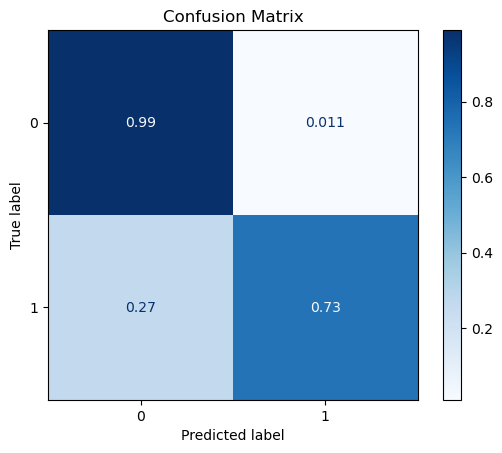

\nClassification Report:
               precision    recall  f1-score   support

No Transition       0.97      0.99      0.98      1720
   Transition       0.86      0.73      0.79       165

     accuracy                           0.97      1885
    macro avg       0.92      0.86      0.89      1885
 weighted avg       0.97      0.97      0.97      1885



In [10]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='transductive',
    label_type='binary',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for binary classification
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'random_state': random_state,
    'n_jobs': -1
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Print detailed classification report
print("\\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Transition', 'Transition']))



Top 20 Features by Importance:
                                   Feature  Importance
348      out_deg_l1_max_consecutive_change    0.127517
312       in_deg_l0_max_consecutive_change    0.082477
315      out_deg_l0_max_consecutive_change    0.047828
243                          in_deg_l1_std    0.015647
345       in_deg_l1_max_consecutive_change    0.015036
288              cv_max_consecutive_change    0.011439
321  avg_path_trad0_max_consecutive_change    0.010336
46                           ang_sec_l0_t1    0.009225
207                                 br_std    0.008604
318       avg_path0_max_consecutive_change    0.007531
227                     avg_path_trad0_std    0.007368
299                       ang_sec_l0_slope    0.007340
221                          in_deg_l0_std    0.006845
54                              maxe_l1_t1    0.006796
200                               rho_mean    0.006763
368                          sece_l2_slope    0.006596
115                          out_

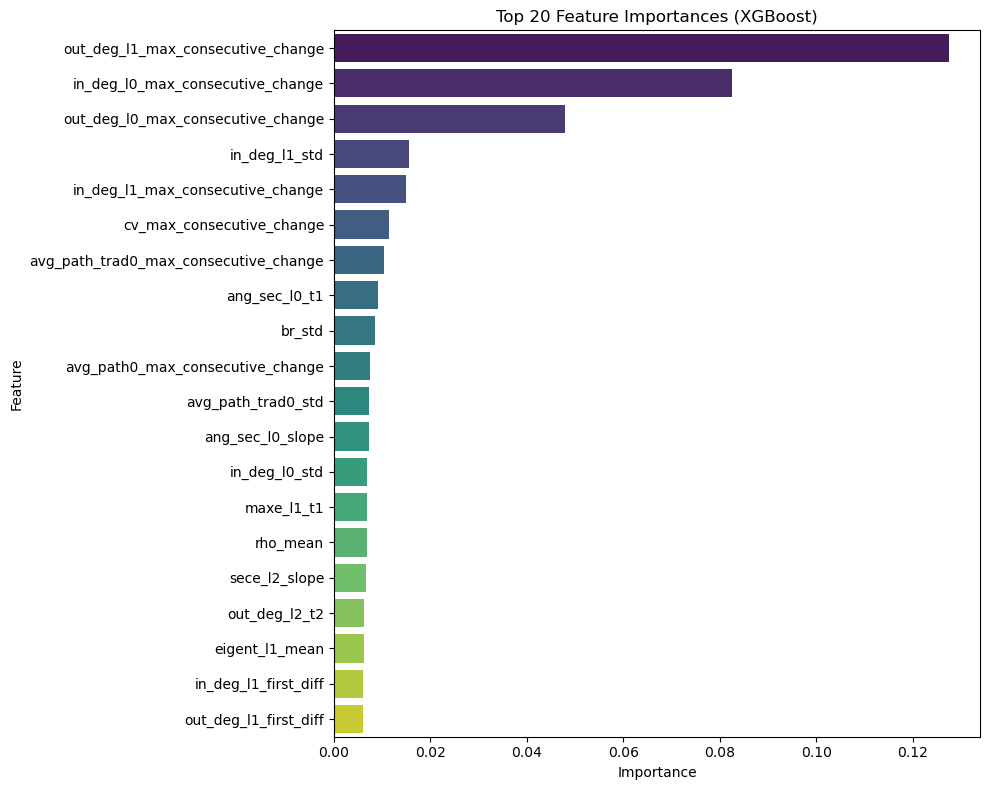

In [11]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Hyperparameter optimization

### Simple random search

In [12]:
# make validation set from training set

rs = 42

train_df = processed_df.iloc[split['X_train'].index]

train_processor = utils.TimeSeriesMLProcessor(pd.DataFrame())

train_processor.processed_data = train_df

split = train_processor.create_balanced_splits(
    split_type='transductive',
    label_type='binary',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']


from sklearn.model_selection import ParameterSampler

# Define search space (same as your param_grid)
param_grid = {
    'n_estimators': [20, 50, 100, 120, 150, 200, 250],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Generate random samples of hyperparameters
n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=rs))

best_score = -np.inf
best_params = None
best_model = None

for params in param_list:
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=rs,
        verbosity=0,
        nthread=5,
        **params
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = model.predict(X_valid)
    score = balanced_accuracy_score(y_valid, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("\nBest parameters:", best_params)
print("Best balanced accuracy on validation set: %.4f" % best_score)



/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_clas


Best parameters: {'subsample': 0.9, 'scale_pos_weight': 7, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best balanced accuracy on validation set: 0.8682


### Testing with hyperparameters from simple random search

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.8664
   Test AUC: 0.9492



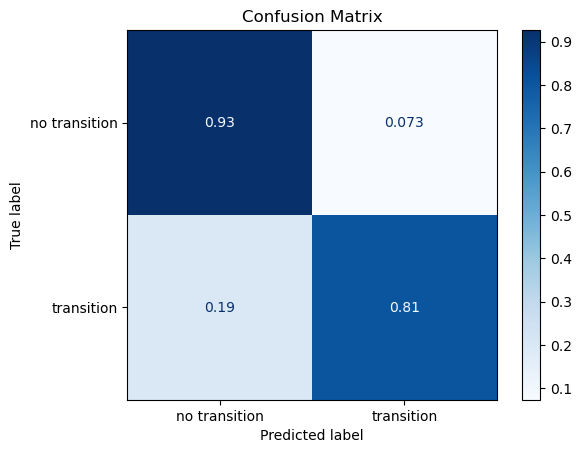

In [13]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='transductive',
    label_type='binary',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for classification
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': random_state,
    'nthread': 5,
    **best_params
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'no transition', 1:'transition'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Sklearn random hp optimization

In [14]:
# Create scorer
scorer = make_scorer(balanced_accuracy_score)

# Create base model
base_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=rs,
    nthread = 5,
    verbosity=0
)

rs = 42
split = train_processor.create_balanced_splits(
    split_type='transductive',
    label_type='binary',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']

# Create a predefined split to use your exact train/validation split
# Mark training samples as -1 and validation samples as 0
X_combined = np.vstack([X_train, X_valid])
y_combined = np.hstack([y_train, y_valid])
test_fold = np.hstack([np.full(len(X_train), -1), np.zeros(len(X_valid))])

ps = PredefinedSplit(test_fold)
n_iter = 100
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=n_iter,
    scoring=scorer,
    cv=ps,  # Use your predefined split
    random_state=rs,
)

random_search.fit(X_combined, y_combined)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None...
                                           use_label_encoder=False,
                                           validate_parameters=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [20, 50, 100, 120, 150,
                                                         200, 250],
                                        'scale_pos_weight': [1, 2, 3, 4, 5, 6,
                                                             7],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score))

### Testing with sklearn random search hyperparameters

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.8642
   Test AUC: 0.9491



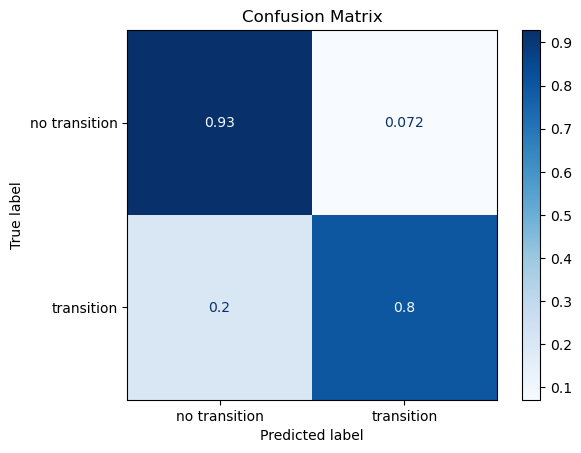

In [15]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='transductive',
    label_type='binary',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']


# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': random_state,
    **best_params
}
xgb_params = random_search.best_params_
# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'no transition', 1:'transition'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]


# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



Top 20 Features by Importance:
                                   Feature  Importance
348      out_deg_l1_max_consecutive_change    0.079383
312       in_deg_l0_max_consecutive_change    0.060057
324         maxe_l1_max_consecutive_change    0.035219
315      out_deg_l0_max_consecutive_change    0.033990
288              cv_max_consecutive_change    0.029378
245                         out_deg_l1_std    0.026918
207                                 br_std    0.022844
223                         out_deg_l0_std    0.021885
221                          in_deg_l0_std    0.017239
179                           eigvar_l1_t4    0.014802
225                          avg_path0_std    0.012454
199                      avg_path_trad2_t4    0.010894
138                              spg_l1_t3    0.010893
321  avg_path_trad0_max_consecutive_change    0.010633
162                                  cv_t4    0.010578
345       in_deg_l1_max_consecutive_change    0.010305
142                          out_

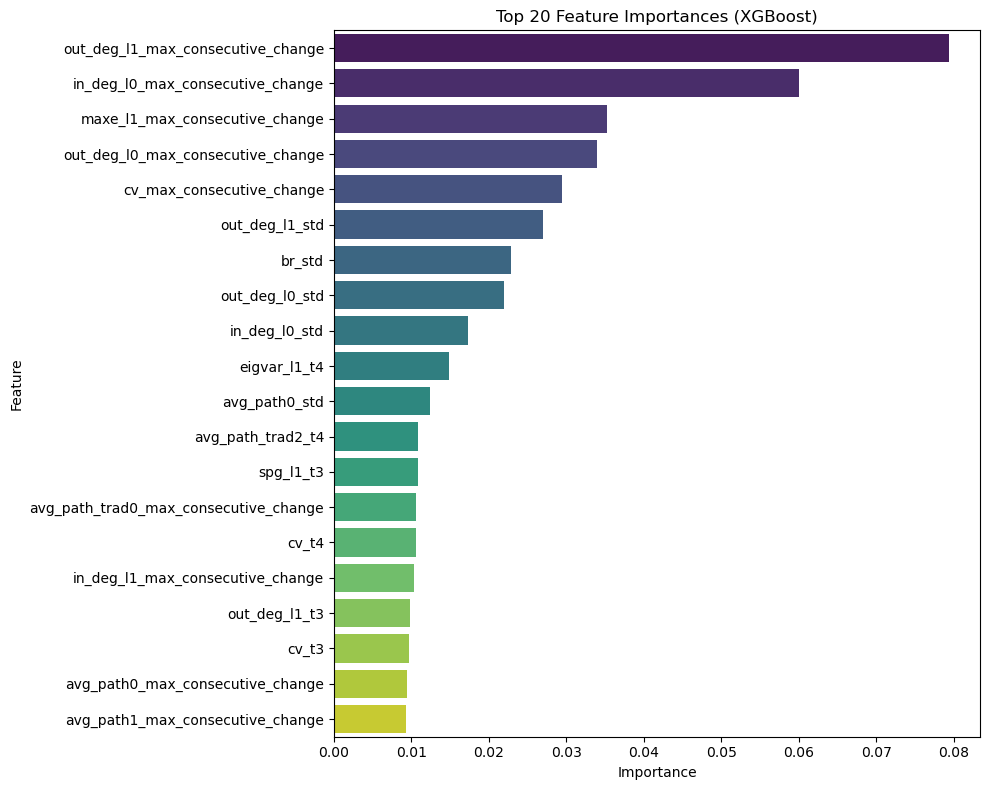

In [16]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
